# Initialisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
train = pd.read_csv("/home/maylin/Downloads/data_v6.csv")
test = pd.read_csv("/home/maylin/Downloads/data_v6.csv")
validation = pd.read_csv("/home/maylin/Downloads/data_v6.csv")

In [9]:
X_train = train.drop(["loc_initiator_x", "loc_initiator_y"], axis=1)
y_train = pd.DataFrame(train[["loc_initiator_x", "loc_initiator_y"]])

X_test = test.drop(["loc_initiator_x", "loc_initiator_y"], axis=1)
y_test = pd.DataFrame(test[["loc_initiator_x", "loc_initiator_y"]])

X_valid = validation.drop(["loc_initiator_x", "loc_initiator_y"], axis=1)
y_valid = pd.DataFrame(validation[["loc_initiator_x", "loc_initiator_y"]])

# Entrainement du modele

In [10]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tqdm import tqdm
import keras.backend as K
from keras.losses import MeanSquaredError
from keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam


cst_nb_neuronne = 256 #512
cst_drop_out = 0 #0.2
nb_couche = 8

neuronal_reseau = []

for nb in tqdm(range(nb_couche)):
  neuronal_reseau += [
    layers.Dense(cst_nb_neuronne, activation='relu'),
    layers.BatchNormalization(), 
    layers.Dropout(cst_drop_out)]

def get_model():
  return keras.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],))]
    + [layers.BatchNormalization()]
    + neuronal_reseau
    + [layers.BatchNormalization()]
    + [layers.Dense(2)])

model = get_model()

model.compile(optimizer=Adam(), loss=["mae"], metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

early_stopping = callbacks.EarlyStopping(min_delta=0.001,
                                         patience=20,
                                         restore_best_weights=True)

lr_rop = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience= 5,
                                              factor = np.sqrt(0.2), verbose = 1,
                                              min_lr = 5e-10)

100%|██████████| 8/8 [00:00<00:00, 298.56it/s]


Epoch 1/250
31/31 [==============================] - 4s 30ms/step - loss: 3.1685 - root_mean_squared_error: 4.3144 - val_loss: 3.6075 - val_root_mean_squared_error: 4.7445 - lr: 0.0010
Epoch 2/250
31/31 [==============================] - 1s 20ms/step - loss: 2.4450 - root_mean_squared_error: 3.5594 - val_loss: 3.2111 - val_root_mean_squared_error: 4.1103 - lr: 0.0010
Epoch 3/250
31/31 [==============================] - 1s 20ms/step - loss: 1.3725 - root_mean_squared_error: 2.2283 - val_loss: 1.0875 - val_root_mean_squared_error: 1.3218 - lr: 0.0010
Epoch 4/250
31/31 [==============================] - 1s 23ms/step - loss: 0.5678 - root_mean_squared_error: 0.8689 - val_loss: 1.8570 - val_root_mean_squared_error: 2.3989 - lr: 0.0010
Epoch 5/250
31/31 [==============================] - 1s 21ms/step - loss: 0.4508 - root_mean_squared_error: 0.6528 - val_loss: 1.8416 - val_root_mean_squared_error: 2.7999 - lr: 0.0010
Epoch 6/250
31/31 [==============================] - 1s 20ms/step - loss: 0

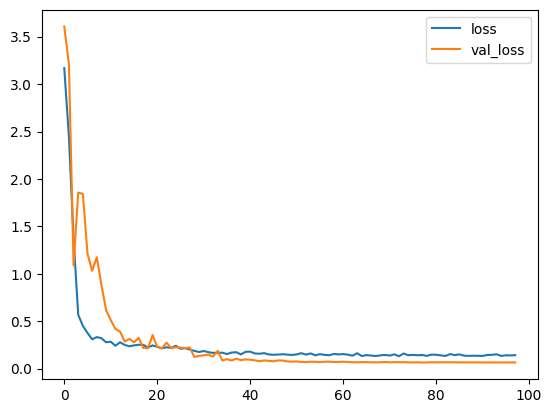

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size = 128,
    epochs = 250,
    callbacks=[early_stopping, lr_rop]
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [72]:
from datetime import datetime

curr_time = str(datetime.now())
curr_time = curr_time[:10] + '_H' + curr_time[11:13]+'m'+curr_time[14:16]+'s'+curr_time[17:19]

model.save("modele_loss_"+str(round(history_df['val_loss'].min(),2))+"_"+curr_time)

INFO:tensorflow:Assets written to: modele_loss_0.06_2023-01-10_H14m26s34/assets


# Prediction

In [17]:
deep_pred = model.predict(X_test)

124/124 [==============================] - 1s 3ms/step


In [19]:
df1 = pd.DataFrame(deep_pred, index=X_test.index, columns=['prediction_x', 'prediction_y'])
df2 = y_test
result = pd.concat([df1, df2, X_test], axis=1)

In [26]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

true = result[["loc_initiator_y", "loc_initiator_x"]]
pred = result[["prediction_y", "prediction_x"]]

print("mean_absolute_error", mean_absolute_error(true, pred))
print("root_mean_squared_error", mean_squared_error(true, pred, squared=False))

mean_absolute_error 0.06500668235311594
root_mean_squared_error 0.12276646972661454
